## Michael Beven - 455613
## University of Chicago - Financial Mathematics
## FINM 33150 - Quantitative Strategies and Regression
## Homework 3

### Tables and column descriptions

* **The strategy dataframe**: 
 * Index: Date
 * ``` XP ``` ~ Adjusted price of security X
 * ``` XV ``` ~ Adjusted volume of security X
 * ``` YP ``` ~ Adjusted price of security Y
 * ``` YV ``` ~ Adjusted volume of security Y
 * ``` XDDV ``` ~ Daily dollar volume of security X
 * ``` Nt ``` ~ 15 day rolling median of ``` XDDV ```
 * ``` XR ``` ~ Log return of X
 * ``` YR ``` ~ Log return of Y
 * ``` Delta ``` ~ ``` XR ``` - ``` YR ```
 * ``` DeltaM ``` ~ M day sume of ``` Delta ```
 * ``` Signal ``` ~ Buy, short, exit signal (-1, 0 or 1)
 * ``` EOM ``` ~ End of month indicator
 * ``` Entry ``` ~ Entry day indicator
 * ``` Exit ``` ~ Exit day indicator
 * ``` Nx ``` ~ Number of X shares bought/shorted
 * ``` Ny ``` ~ Number of Y shares bought/shorted
 * ``` Profit ``` ~ ``` Signal ```(``` Nx ``` $\times$ ``` XR ``` + ``` Ny ``` $\times$ ``` YR```)
 * ``` Cum_Profit ``` ~ Cumulative profit
 * ``` K ``` ~ Cumulative capital
 * ``` Return  ``` ~ Annualised ``` Profit ``` / ``` K ```


* **ETF simulation arguments** (``` sims ```): 
 * Index: ETF number
 * ``` M ``` ~ Number of days for the M day return
 * ``` g ``` ~ Entry barrier
 * ``` j ``` ~ Exit barrier
 * ``` X_code ``` ~ Quandl code of security X
 * ``` Y_code ``` ~ Quandl code of security Y
 * ``` X_close ``` ~ Column name for adjusted close price of X
 * ``` X_volume ``` ~ Column name for adjusted volume of X
 * ``` Y_close ``` ~ Column name for adjusted close price of Y
 * ``` Y_colume ``` ~ Column name for adjusted volume of Y
 
 
* **Fama-French daily factor returns, annualised** (``` FF_data ```): 
 * ``` Mkt-RF ``` ~ Market return
 * ``` SMB ``` ~ Small minus big return
 * ``` HML ``` ~ High minus low return
 * ``` RF ``` ~ Risk free return
 
 
* **Sharpe and Sortino ratios on returns** (``` Ratios ```): 
 * Index: ETF number
 * ``` Sharpe ``` ~ Sharpe ratio: $\frac{E[r-r_b]}{\sqrt{E[(r-r_b)^2]}}$
 * ``` Sortino ``` ~ Sortino ratio: $\frac{E[r-r_b]}{\sqrt{E[(r-r_b)^2 | r < r_b]}}$
 
 
* **Individual regressions** (``` Indiv ```): 
 * Index: ETF number
 * ``` SMB ``` ~ SMB regression coefficient (hedge ratio)
 * ``` SMB Sharpe ``` ~ SMB regression Sharpe ratio
 * ``` SMB Sortino ``` ~ SMB regression Sortino ratio
 * ``` HML ``` ~ HML regression coefficient (hedge ratio)
 * ``` HML Sharpe ``` ~ HML regression Sharpe ratio
 * ``` HML Sortino ``` ~ HML regression Sortino ratio
 * ``` RF ``` ~ RF regression coefficient (hedge ratio)
 * ``` RF Sharpe ``` ~ RF regression Sharpe ratio
 * ``` RF Sortino ``` ~ RF regression Sortino ratio
 * ``` Mkt-RF ``` ~ Mkt-RF regression coefficient (hedge ratio)
 * ``` Mkt-RF Sharpe ``` ~ Mkt-RF regression Sharpe ratio
 * ``` Mkt-RF Sortino ``` ~ Mkt-RF regression Sortino ratio
 
 
* **Improvements from individual regressions** (``` Improv_Indiv ```):
 * ``` SMB Sharpe ``` ~ Improvement in Sharpe ratio from SMB regression
 * ``` SMB Sortino ``` ~ Improvement in Sortino ratio from SMB regression
 * ``` HML Sharpe ``` ~ Improvement in Sharpe ratio from HML regression
 * ``` HML Sortino ``` ~ Improvement in Sortino ratio from HML regression
 * ``` RF Sharpe ``` ~ Improvement in Sharpe ratio from RF regression
 * ``` RF Sortino ``` ~ Improvement in Sortino ratio from RF regression
 * ``` Mkt-RF Sharpe ``` ~ Improvement in Sharpe ratio from Mkt-RF regression
 * ``` Mkt-RF Sortino ``` ~ Improvement in Sortino ratio from Mkt-RF regression
 
 
* **Multivariate regressions** (``` Multi ```): 
 * Index: ETF number
 * ``` SMB ``` ~ SMB regression coefficient (hedge ratio)
 * ``` HML ``` ~ HML regression coefficient (hedge ratio)
 * ``` RF ``` ~ RF regression coefficient (hedge ratio)
 * ``` Mkt-RF ``` ~ Mkt-RF regression coefficient (hedge ratio)
 * ``` Sharpe ``` ~ Regression Sharpe ratio
 * ``` Sortino ``` ~ Regression Sortino ratio
 
 
* **Improvements from multivariate regressions** (``` Improv_Multi ```):
 * ``` Sharpe ``` ~ Improvement in Sharpe ratio from regression
 * ``` Sortino ``` ~ Improvement in Sortino ratio from regression

### Code and Analysis


**First we retrieve all necessary packages and set global variables: **

In [30]:
# Michael Beven - 455613
# University of Chicago - Financial Mathematics
# FINM 33150 - Quantitative Strategies and Regression
# Homework 3 

# make plots come up in this window - ipython notebook
%matplotlib inline

# import packages
import pandas as pd
import numpy as np
import Quandl
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# set global variables
auth = "v21snmSix9KyXBWc1RkF"
start_date = "2013-12-02"
trade_begin = "2014-01-01"
end_date = "2015-12-31"



**Next is the same function as in Homework 2, except without the stop loss:**



In [31]:
# reversion strategy function
def strat(M,g,j,X_code,Y_code,X_close,X_volume,Y_close,Y_volume):
  """
  This function creates a dataframe with results to a spread trading strategy
  (see HW2 of FINM 33150 - Quantitative Strategies and Regression)
  Inputs:
  M ~ return difference calculation time frame.  M cannot exceed the number of 
  trading days between 2013-12-02 and 2014-01-01
  g ~ entering threshold
  j ~ exiting threshold
  s ~ stop loss threshold
  X_code ~ Quandl code for X
  Y_code ~ Quandl code for Y
  X_close ~ X column name for close
  X_volume ~ X column name for volume
  Y_close ~ Y column name for close
  Y_volume ~ Y column name for volume
  Example of calling function:
  strat(10,0.01,0.008,0.10,'GOOG/NYSE_XSD','YAHOO/SMH','GOOG.NYSE_XSD - Close',
  'GOOG.NYSE_XSD - Volume','YAHOO.SMH - Close','YAHOO.SMH - Volume')
  """
  # grab data using Quandl
  ETF_data = Quandl.get(list((X_code,Y_code)),authtoken=auth,trim_start=start_date,trim_end=end_date,returns="pandas")
  df = pd.DataFrame(ETF_data.ix[:,(X_close,X_volume,Y_close,Y_volume)]) #subset
  df.columns = ['XP','XV','YP','YV']
  df['XDDV'] = df.XP*df.XV # calculate daily dollar volumes
  df['Nt'] = pd.rolling_median(df.XDDV,15).shift(1)# 15 day rolling median
  K = np.max(2*df.Nt) # capital - set K now that we have Nt
  df['XR'] = np.log(df.XP) - np.log(df.XP.shift(1)) #logrets
  df['YR'] = np.log(df.YP) - np.log(df.YP.shift(1))
  df['Delta'] = df.XR-df.YR # difference of X and Y
  df['DeltaM'] = pd.rolling_sum(df.Delta,M).shift(1) #M day historical accumulated difference 
  df = df[df.index >= trade_begin] # drop unnecessary date range
  df['Signal'] = np.nan # add empty trade signal column
  df.Signal[df.DeltaM > g] = 1 # entering or maintaining trade
  df.Signal[df.DeltaM < -g] = -1 # entering or maintaining trade
  df.Signal[np.abs(df.DeltaM) < j] = 0 # exiting or out of trade
  df['EOM'] = np.nan # end of month
  df.EOM[(df.shift(1,freq='B').index.day <= 3) & (df.shift(1,freq='B').index.day-df.index.day < -1)] = 1 # day before 1st day
  df.Signal[(df.shift(1,freq='B').index.day <= 3) & (df.shift(1,freq='B').index.day-df.index.day < -1)] = 0
  df.Signal[((df.Signal == -1) & (df.DeltaM > j)) | (df.Signal == 1) & (df.DeltaM < j)] = 0
  for i in range(1,len(df)):
    if np.isnan(df.Signal[i]):# if between g and j
      df.Signal[i] = df.Signal[i-1] # fill in with current position
  df['Entry'] = 1*(((df.Signal == 1) | (df.Signal == -1)) & ((df.shift(1).Signal == 0) | (np.isnan(df.shift(1).Signal) == True))) # entry point
  df.Entry[((df.Signal == -1) & (df.shift(1).Signal == 1)) | ((df.Signal == 1) & (df.shift(1).Signal == -1))] = 1 # jumping g to -g or vice versa
  df['Exit'] = 1*((df.Signal == 0) & ((df.shift(1).Signal == 1) | ((df.shift(1).Signal == -1)))) # exit point
  df['Nx'] = np.round(-df.Signal*df.Nt/100/df.XP,0) # size of X trade
  df['Ny'] = np.round(df.Signal*df.Nt/100/df.YP,0) # size of Y trade
  df['Profit'] = pd.DataFrame((df.Nx.shift(1)*df.XP.shift(1)*df.XR)+df.Ny.shift(1)*df.YP.shift(1)*df.YR) # dollar profit(loss)
  df['Cum_Profit'] = np.cumsum(df.Profit) #cumulative profit
  df['K'] = np.round(K + df.Cum_Profit,0) # capital based on changes in profit  
  df['Return'] = 252*df.Profit/df.K.shift(1) # annualised returns  
  return df


**Then a dataframe is created, where each row number contains all arguments to its corresponding ETF.  The index of the dataframe is the ETF number.  This dataframe is printed below:**


In [32]:
# set up a dataframe of the simulations to run
sims = pd.DataFrame(columns=['M','g','j','X_code','Y_code','X_close','X_volume','Y_close','Y_volume'])
sims.loc[0] = [20,0.02,0.005,'EOD/RYU','EOD/XLU','EOD.RYU - Adj_Close','EOD.RYU - Adj_Volume','EOD.XLU - Adj_Close','EOD.XLU - Adj_Volume']
sims.loc[1] = [20,0.060,0.028,'EOD/IST','EOD/IYZ','EOD.IST - Adj_Close','EOD.IST - Adj_Volume','EOD.IYZ - Adj_Close','EOD.IYZ - Adj_Volume']
sims.loc[2] = [20,0.021,0.016,'EOD/RING','EOD/GDX','EOD.RING - Adj_Close','EOD.RING - Adj_Volume','EOD.GDX - Adj_Close','EOD.GDX - Adj_Volume']
sims.loc[3] = [20,0.05,0.048,'EOD/XSD','EOD/SMH','EOD.XSD - Adj_Close','EOD.XSD - Adj_Volume','EOD.SMH - Adj_Close','EOD.SMH - Adj_Volume']
sims.loc[4] = [20,0.05,0.036,'EOD/PBE','EOD/XBI','EOD.PBE - Adj_Close','EOD.PBE - Adj_Volume','EOD.XBI - Adj_Close','EOD.XBI - Adj_Volume']
sims.loc[5] = [20,0.025,0.006,'EOD/PXJ','EOD/OIH','EOD.PXJ - Adj_Close','EOD.PXJ - Adj_Volume','EOD.OIH - Adj_Close','EOD.OIH - Adj_Volume']
sims.loc[6] = [20,0.07,0.064,'EOD/IEO','EOD/XOP','EOD.IEO - Adj_Close','EOD.IEO - Adj_Volume','EOD.XOP - Adj_Close','EOD.XOP - Adj_Volume']
sims.loc[7] = [20,0.038,0.012,'EOD/RTH','EOD/XRT','EOD.RTH - Adj_Close','EOD.RTH - Adj_Volume','EOD.XRT - Adj_Close','EOD.XRT - Adj_Volume']
sims.loc[8] = [20,0.002,0.0003,'EOD/SIVR','EOD/SLV','EOD.SIVR - Adj_Close','EOD.SIVR - Adj_Volume','EOD.SLV - Adj_Close','EOD.SLV - Adj_Volume']
sims.loc[9] = [20,0.08,0.078,'EOD/HYLD','EOD/JNK','EOD.HYLD - Adj_Close','EOD.HYLD - Adj_Volume','EOD.JNK - Adj_Close','EOD.JNK - Adj_Volume']
sims = sims.set_index(np.array(['ETF0','ETF1','ETF2','ETF3','ETF4','ETF5','ETF6','ETF7','ETF8','ETF9']))
print(sims)

       M      g       j    X_code   Y_code               X_close  \
ETF0  20  0.020  0.0050   EOD/RYU  EOD/XLU   EOD.RYU - Adj_Close   
ETF1  20  0.060  0.0280   EOD/IST  EOD/IYZ   EOD.IST - Adj_Close   
ETF2  20  0.021  0.0160  EOD/RING  EOD/GDX  EOD.RING - Adj_Close   
ETF3  20  0.050  0.0480   EOD/XSD  EOD/SMH   EOD.XSD - Adj_Close   
ETF4  20  0.050  0.0360   EOD/PBE  EOD/XBI   EOD.PBE - Adj_Close   
ETF5  20  0.025  0.0060   EOD/PXJ  EOD/OIH   EOD.PXJ - Adj_Close   
ETF6  20  0.070  0.0640   EOD/IEO  EOD/XOP   EOD.IEO - Adj_Close   
ETF7  20  0.038  0.0120   EOD/RTH  EOD/XRT   EOD.RTH - Adj_Close   
ETF8  20  0.002  0.0003  EOD/SIVR  EOD/SLV  EOD.SIVR - Adj_Close   
ETF9  20  0.080  0.0780  EOD/HYLD  EOD/JNK  EOD.HYLD - Adj_Close   

                   X_volume              Y_close              Y_volume  
ETF0   EOD.RYU - Adj_Volume  EOD.XLU - Adj_Close  EOD.XLU - Adj_Volume  
ETF1   EOD.IST - Adj_Volume  EOD.IYZ - Adj_Close  EOD.IYZ - Adj_Volume  
ETF2  EOD.RING - Adj_Volume  EOD


**Now we can run the strategy function for each ETF and its corresponding arguments:**


In [33]:
# create all data frames
dfs = {}
for i in range(0,len(sims)):
  dfs['df'+str(i)] = strat(sims.ix[i,'M'],sims.ix[i,'g'],sims.ix[i,'j'],sims.ix[i,'X_code'],sims.ix[i,'Y_code'],sims.ix[i,'X_close'],sims.ix[i,'X_volume'],sims.ix[i,'Y_close'],sims.ix[i,'Y_volume'])


** Now import Fama-French data. We would generally import Fama-French data to incorporate into the returns (using ``` RF ``` when we are not in a trade), however ``` RF ``` is zero for the time frame so it makes no difference for this assignment.  The head of Fama-French data (annualised) is printed below. ** 


In [34]:
# FF data (annualised)
FF_data = Quandl.get('KFRENCH/FACTORS_D',authtoken=auth,trim_start=trade_begin,trim_end=end_date,returns="pandas")*252/100
print(FF_data.head())

            Mkt-RF     SMB     HML  RF
Date                                  
2014-01-02 -2.2176 -0.6048  0.2772   0
2014-01-03  0.0756  0.9324  0.0756   0
2014-01-06 -0.8568 -1.4112  0.6552   0
2014-01-07  1.7136  0.9324 -0.9828   0
2014-01-08  0.1008  0.0504 -0.5796   0



**Next we calculate the Sharpe and Sortino ratios for the returns (each ETF's set of ratios are printed below):**


In [35]:
# ratios
Ratios = pd.DataFrame(columns=['Sharpe','Sortino'])
for i in range(0,len(sims)):
  df = dfs['df'+str(i)]
  Sharpe = (df.Return - FF_data.RF).mean()/np.sqrt(np.mean(np.power(df.Return - FF_data.RF,2)))
  Sortino = (df.Return - FF_data.RF).mean()/np.sqrt(np.mean(np.power(df.Return[df.Return < FF_data.RF] - FF_data.RF[df.Return < FF_data.RF],2)))
  Ratios.loc[i] = [Sharpe,Sortino]
Ratios = Ratios.set_index(sims.index)
print(Ratios)

        Sharpe   Sortino
ETF0  0.038316  0.015851
ETF1  0.092688  0.034860
ETF2  0.040901  0.017710
ETF3  0.050674  0.017530
ETF4  0.020968  0.010835
ETF5  0.018517  0.009589
ETF6  0.005100  0.001667
ETF7  0.012806  0.005376
ETF8  0.018817  0.009458
ETF9  0.023210  0.002465


** Then we can run the individual regressions on the returns.  Each beta factor has three outputted columns: the hedge ratio (regression coefficient), Sharpe ratio and Sortino ratio.  Results are printed below:**

In [36]:
# individual regressions
Indiv = pd.DataFrame(columns=['SMB','SMB Sharpe','SMB Sortino','HML','HML Sharpe','HML Sortino','RF','RF Sharpe','RF Sortino','Mkt-RF','Mkt-RF Sharpe','Mkt-RF Sortino'])
for i in range(0,len(sims)):
  df = dfs['df'+str(i)]
  SMB = OLS(df.Return,FF_data.SMB+0,missing='drop').fit()
  SMB_p = SMB.params['SMB']
  SMB_Sharpe = SMB.resid.mean()/np.sqrt(np.mean(np.power(SMB.resid,2)))
  SMB_Sortino = SMB.resid.mean()/np.sqrt(np.mean(np.power(SMB.resid[SMB.resid<0],2)))
  HML = OLS(df.Return,FF_data.HML+0,missing='drop').fit()
  HML_p = HML.params['HML']
  HML_Sharpe = HML.resid.mean()/np.sqrt(np.mean(np.power(HML.resid,2)))
  HML_Sortino = HML.resid.mean()/np.sqrt(np.mean(np.power(HML.resid[HML.resid<0],2)))
  RF = OLS(df.Return,FF_data.RF+0,missing='drop').fit()
  RF_p = RF.params['RF']
  RF_Sharpe = RF.resid.mean()/np.sqrt(np.mean(np.power(RF.resid,2)))
  RF_Sortino = RF.resid.mean()/np.sqrt(np.mean(np.power(RF.resid[RF.resid<0],2)))
  MktRF = OLS(df.Return,FF_data['Mkt-RF']+0,missing='drop').fit()
  MktRF_p = MktRF.params['Mkt-RF']
  MktRF_Sharpe = MktRF.resid.mean()/np.sqrt(np.mean(np.power(MktRF.resid,2)))
  MktRF_Sortino = MktRF.resid.mean()/np.sqrt(np.mean(np.power(MktRF.resid[MktRF.resid<0],2)))
  Indiv.loc[i] = [SMB_p,SMB_Sharpe,SMB_Sortino,HML_p,HML_Sharpe,HML_Sortino,RF_p,RF_Sharpe,RF_Sortino,MktRF_p,MktRF_Sharpe,MktRF_Sortino]
Indiv = Indiv.set_index(sims.index)
print(Indiv)

           SMB  SMB Sharpe  SMB Sortino       HML  HML Sharpe  HML Sortino  \
ETF0  0.000006    0.038913     0.048900  0.000003    0.038654     0.047028   
ETF1  0.000002    0.092770     0.114273 -0.000003    0.092522     0.122335   
ETF2 -0.000143    0.036635     0.058180 -0.000104    0.036644     0.060108   
ETF3  0.000201    0.060049     0.100024 -0.000069    0.046991     0.090176   
ETF4  0.000185    0.024762     0.025786 -0.000161    0.016719     0.018680   
ETF5  0.000030    0.020359     0.021819  0.000033    0.021174     0.021611   
ETF6  0.000324    0.012084     0.013895  0.000043    0.006308     0.006948   
ETF7  0.000191    0.020130     0.019709  0.000030    0.014279     0.013478   
ETF8 -0.000024    0.016030     0.015493  0.000013    0.020985     0.019324   
ETF9  0.000153    0.027484     0.031774  0.000022    0.024013     0.026493   

      RF  RF Sharpe  RF Sortino        Mkt-RF  Mkt-RF Sharpe  Mkt-RF Sortino  
ETF0   0   0.038316    0.015851 -3.521026e-06       0.038731  

** As one can see, the regression for ``` RF ``` yields no regression coefficient and the Sharpe and Sortino ratios are the same as in the ``` Ratios ``` table.  Finally, we run the multivariate regressions.  Results are outputted below:**

In [37]:
# multivariate regression
Multi = pd.DataFrame(columns=['ETF','SMB','HML','RF','Mkt-RF','Sharpe','Sortino'])
for i in range(0,len(sims)):
  df = dfs['df'+str(i)]
  Reg = OLS(df.Return,FF_data+0,missing='drop').fit()
  Reg_p = Reg.params
  Reg_Sharpe = Reg.resid.mean()/np.sqrt(np.mean(np.power(Reg.resid,2)))
  Reg_Sortino = Reg.resid.mean()/np.sqrt(np.mean(np.power(Reg.resid[Reg.resid<0],2)))
  Multi.loc[i] = ['df'+str(i),Reg_p['SMB'],Reg_p['HML'],Reg_p['RF'],Reg_p['Mkt-RF'],Reg_Sharpe,Reg_Sortino]
Multi = Multi.set_index(sims.index)
print(Multi)  

      ETF       SMB       HML  RF    Mkt-RF    Sharpe   Sortino
ETF0  df0  0.000008  0.000005   0 -0.000004  0.040086  0.048840
ETF1  df1  0.000003 -0.000006   0 -0.000013  0.093058  0.113802
ETF2  df2 -0.000189 -0.000183   0 -0.000037  0.029174  0.048297
ETF3  df3  0.000201  0.000006   0  0.000009  0.059932  0.100443
ETF4  df4  0.000152 -0.000092   0  0.000045  0.020500  0.022310
ETF5  df5  0.000044  0.000050   0  0.000005  0.024833  0.025093
ETF6  df6  0.000371  0.000188   0  0.000037  0.017496  0.019160
ETF7  df7  0.000215  0.000133   0  0.000080  0.024061  0.023251
ETF8  df8 -0.000022  0.000006   0  0.000002  0.016855  0.016474
ETF9  df9  0.000172  0.000103   0  0.000060  0.029768  0.033385


** We can make more sense of the results by looking at them visually: **

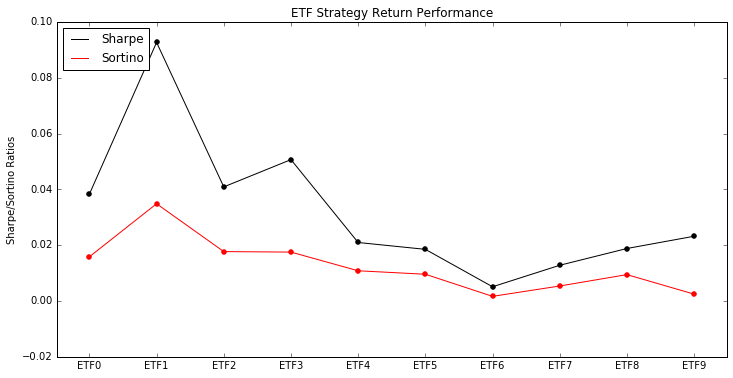

In [38]:
# plots
x_ax = np.array([0,1,2,3,4,5,6,7,8,9]) # string axis

plt.figure(1,figsize=(12,6))
plt.xticks(x_ax,sims.index)
plt.title('ETF Strategy Return Performance')
plt.ylabel('Sharpe/Sortino Ratios')
plt.plot(x_ax,Ratios.Sharpe,color='black')
plt.scatter(x_ax,Ratios.Sharpe,color='black')
plt.plot(x_ax,Ratios.Sortino,color='red')
plt.scatter(x_ax,Ratios.Sortino,color='red')
plt.legend(['Sharpe','Sortino'],loc='upper left')

** The above plot shows the Sharpe and Sortino ratios of the reversion strategy on each ETF pair.  These ratio values are quite low compared to industry accepted standards of 'good' Sharpe and Sortino ratios.  The reversion strategy may have a poor performance due to several caveats, such as: exiting the strategy at the end of each month (regardless of a profitable situation), no stop-loss, constraints on usage of capital, etc.  Also note that the Sharpe ratio is consistently above the Sortino ratio.  If the strategy produced exactly normal returns, the Sharpe and Sortino ratios would be identical, however the fact that they aren't suggests returns are not normal.  We can further investigate this by looking at each QQ-Plot of an ETF pair's returns:**

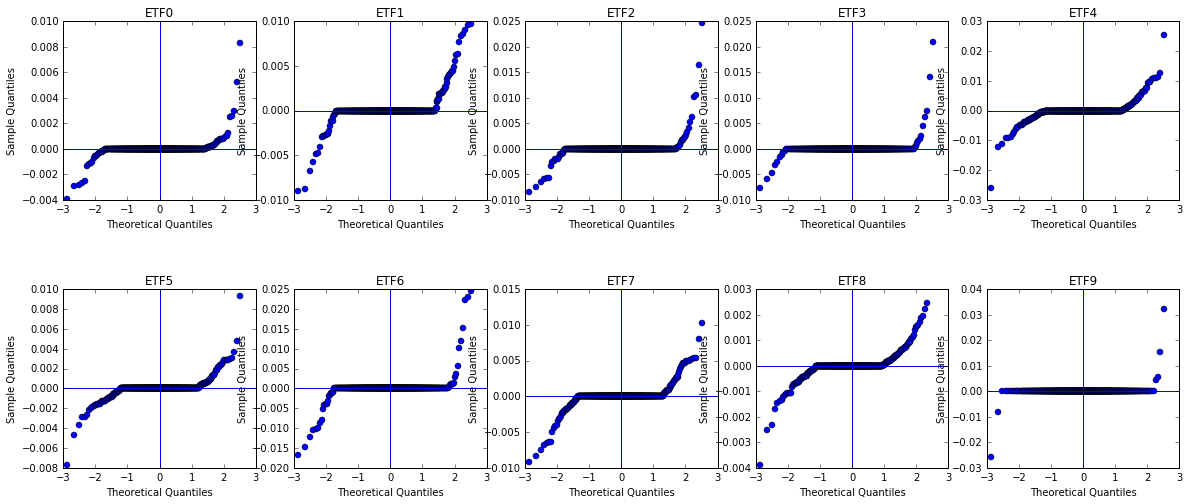

In [39]:
fig = plt.figure(4,figsize=(20,8))
plt.subplots_adjust(hspace=0.5)
for i in range(0,len(sims)):
  ax = fig.add_subplot(2,5,i+1)
  sm.graphics.qqplot(dfs['df'+str(i)].Return,ax=ax)
  plt.axvline(x=0)
  plt.axhline(y=0)
  plt.title('ETF{}'.format(i))

** Indeed, the returns are always heavy-tailed, which means higher Sharpe ratios is reasonable.  We can also look at how individual regressions have improved our performance ratios: **

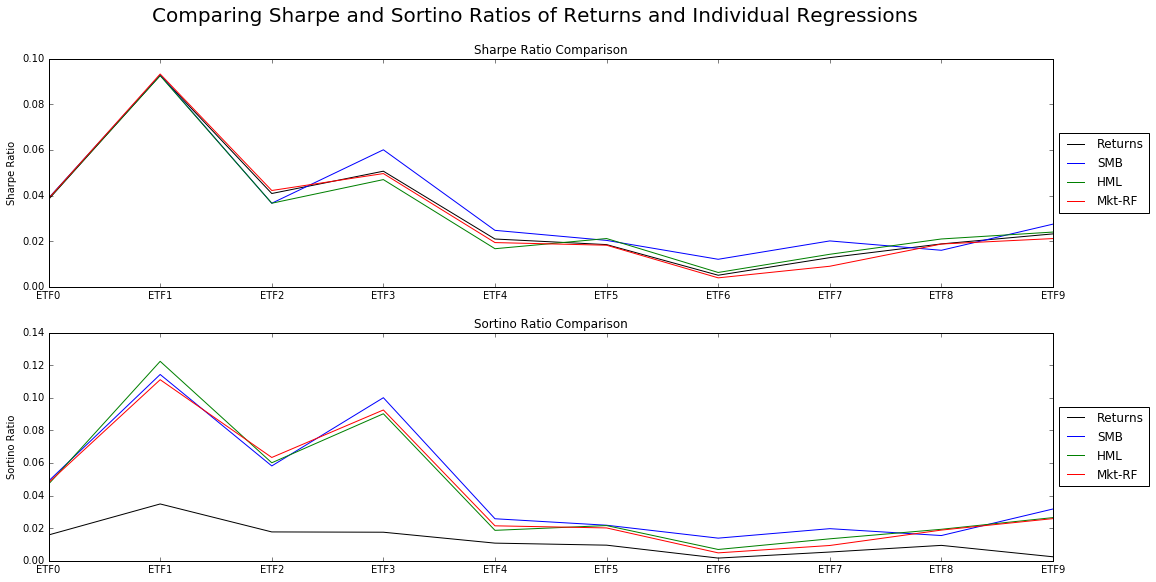

In [40]:
plt.figure(2,figsize=(18,9))
plt.suptitle('Comparing Sharpe and Sortino Ratios of Returns and Individual Regressions',fontsize=20)
plt.subplot(211)
plt.xticks(x_ax,sims.index)
plt.plot(x_ax,Ratios['Sharpe'],color='black')
plt.plot(x_ax,Indiv['SMB Sharpe'])
plt.plot(x_ax,Indiv['HML Sharpe'])
plt.plot(x_ax,Indiv['Mkt-RF Sharpe'])
plt.title('Sharpe Ratio Comparison')
plt.ylabel('Sharpe Ratio')
plt.legend(['Returns','SMB','HML','Mkt-RF'],loc='center left',bbox_to_anchor=(1, 0.5))
plt.subplot(212)
plt.xticks(x_ax,sims.index)
plt.plot(x_ax,Ratios['Sortino'],color='black')
plt.plot(x_ax,Indiv['SMB Sortino'])
plt.plot(x_ax,Indiv['HML Sortino'])
plt.plot(x_ax,Indiv['Mkt-RF Sortino'])
plt.title('Sortino Ratio Comparison')
plt.ylabel('Sortino Ratio')
plt.legend(['Returns','SMB','HML','Mkt-RF'],loc='center left',bbox_to_anchor=(1, 0.5))

** The above plots suggest that hedging with Fama-French factors has minimal effect on performance in terms of the Sharpe ratio.  However, the Fama-French hedges improve the Sortino ratios.  This suggests that the strategy hedges work in periods of negative returns.  We can also do the same analysis for multivariate regressions:**

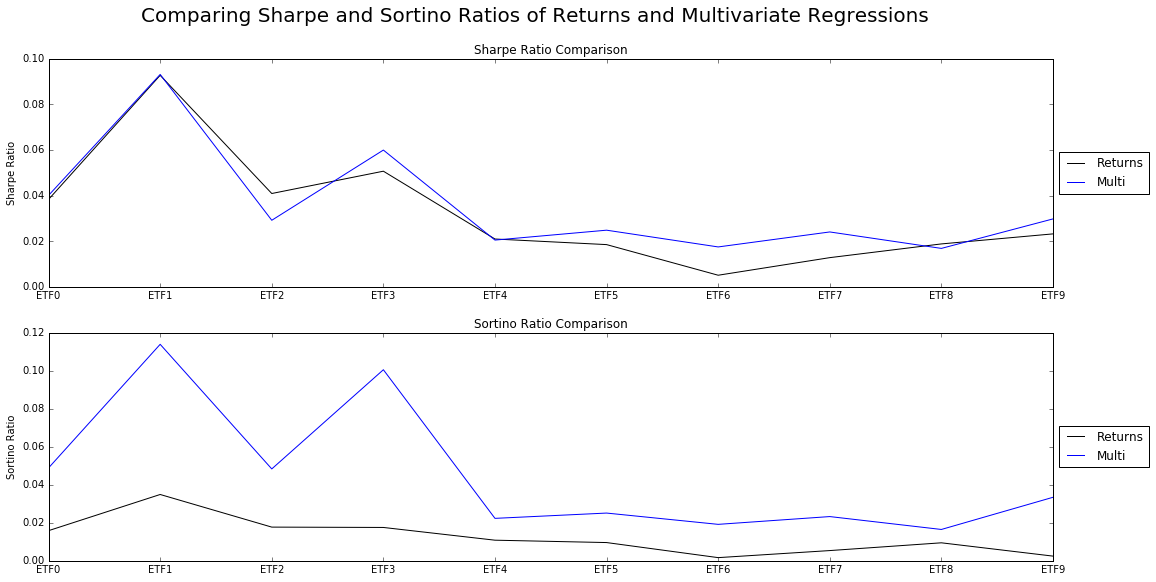

In [41]:
plt.figure(3,figsize=(18,9))
x_ax = np.array([0,1,2,3,4,5,6,7,8,9])
plt.suptitle('Comparing Sharpe and Sortino Ratios of Returns and Multivariate Regressions',fontsize=20)
plt.subplot(211)
plt.xticks(x_ax,sims.index)
plt.plot(x_ax,Ratios['Sharpe'],color='black')
plt.plot(x_ax,Multi['Sharpe'])
plt.title('Sharpe Ratio Comparison')
plt.ylabel('Sharpe Ratio')
plt.legend(['Returns','Multi'],loc='center left',bbox_to_anchor=(1, 0.5))
plt.subplot(212)
plt.xticks(x_ax,sims.index)
plt.plot(x_ax,Ratios['Sortino'],color='black')
plt.plot(x_ax,Multi['Sortino'])
plt.title('Sortino Ratio Comparison')
plt.ylabel('Sortino Ratio')
plt.legend(['Returns','Multi'],loc='center left',bbox_to_anchor=(1, 0.5))

** The multivariate hedge yields a similar result; the strategy performance for each ETF pair varies with regards to the Sharpe ratio, however the performance under the Sortino ratio is consistently higher. This makes sense: if the Sortino ratio is consistently higher for individual hedges, we would expect the multivariate Sortino ratio to also be higher.  Finally, let's look at the differences in ratios (improvements) for the individual and multivariate regressions: **

In [42]:
# improvement individual regressions
Improv_Indiv = pd.DataFrame()
Improv_Indiv['SMB Sharpe'] = Indiv['SMB Sharpe'] - Ratios['Sharpe']
Improv_Indiv['SMB Sortino'] = Indiv['SMB Sortino'] - Ratios['Sortino']
Improv_Indiv['HML Sharpe'] = Indiv['HML Sharpe'] - Ratios['Sharpe']
Improv_Indiv['HML Sortino'] = Indiv['HML Sortino'] - Ratios['Sortino']
Improv_Indiv['RF Sharpe'] = Indiv['RF Sharpe'] - Ratios['Sharpe']
Improv_Indiv['RF Sortino'] = Indiv['RF Sortino'] - Ratios['Sortino']
Improv_Indiv['Mkt-RF Sharpe'] = Indiv['Mkt-RF Sharpe'] - Ratios['Sharpe']
Improv_Indiv['Mkt-RF Sortino'] = Indiv['Mkt-RF Sortino'] - Ratios['Sortino']
Improv_Indiv = Improv_Indiv.set_index(sims.index)
print(Improv_Indiv)

      SMB Sharpe  SMB Sortino  HML Sharpe  HML Sortino  RF Sharpe  RF Sortino  \
ETF0    0.000598     0.033049    0.000338     0.031177          0           0   
ETF1    0.000082     0.079412   -0.000166     0.087475          0           0   
ETF2   -0.004266     0.040470   -0.004257     0.042398          0           0   
ETF3    0.009376     0.082494   -0.003682     0.072646          0           0   
ETF4    0.003794     0.014951   -0.004249     0.007845          0           0   
ETF5    0.001842     0.012230    0.002657     0.012023          0           0   
ETF6    0.006983     0.012229    0.001208     0.005281          0           0   
ETF7    0.007324     0.014332    0.001473     0.008102          0           0   
ETF8   -0.002787     0.006035    0.002168     0.009866          0           0   
ETF9    0.004274     0.029309    0.000803     0.024029          0           0   

      Mkt-RF Sharpe  Mkt-RF Sortino  
ETF0       0.000415        0.032095  
ETF1       0.000557        0.076

** As expected, there is no change for regressions with ``` RF ```.  The ``` SMB ``` factor hedge has generally improved performance in terms of Sharpe ratio, and has always improved performance in terms of Sortino ratio.  ``` HML ``` and ``` Mkt-RF ``` factors on the other hand seem to often decrease performance of the strategy (increase variance relative to mean returns), although the Sortino ratios indicate an increase in performance for ``` HML ``` and ``` Mkt-RF ``` hedges with returns are negative.  **

In [43]:
# improvement multivariate regression
Improv_Multi = pd.DataFrame()
Improv_Multi['Sharpe'] = Multi['Sharpe'] - Ratios['Sharpe']
Improv_Multi['Sortino'] = Multi['Sortino'] - Ratios['Sortino']
Improv_Multi = Improv_Multi.set_index(sims.index)
print(Improv_Multi)

        Sharpe   Sortino
ETF0  0.001770  0.032989
ETF1  0.000370  0.078942
ETF2 -0.011726  0.030587
ETF3  0.009258  0.082913
ETF4 -0.000468  0.011476
ETF5  0.006316  0.015504
ETF6  0.012395  0.017493
ETF7  0.011256  0.017875
ETF8 -0.001962  0.007016
ETF9  0.006558  0.030920


** Again, the multivariate regression improves the Sortino ratio for each pair of ETFs, however sometimes decreases the Sharpe ratio.  From the individual and multivariate benchmark analysis, the most effective hedges appear to be the multivariate regression and the ``` SMB ``` regression.  Both regressions are likely to improve overall performance of the strategy, and are very likely to improve negative returns against variance. **